In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from IPython.display import Video
from matplotlib import animation

The shallow water equations are a set of hyperbolic partial differential equations (or parabolic if viscous shear is considered) that describe the flow below a pressure surface in a fluid (sometimes, but not necessarily, a free surface). We consider a 1D domain, and describe the dynamics of fluid particles in an Eulerian framework. There are two forms of shallow water equations:
(i) Non-conservative form, and, 
(ii) Conservative form. The latter is often used while dealing with discontinuities or sudden changes. In this notebook, we consider the non-conservative form only, and test it on several metrics.

## 1. Non-conservative form

In [2]:
import Euler.Periodic_1D as elr

Rotating 1D shallow water inviscid dynamical equations over a flat bottom are:

$$ \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} - fv = -g\frac{\partial h}{\partial x},$$

$$ \frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + fu = 0, $$

$$ \frac{\partial h}{\partial t} + \frac{\partial (uh)}{\partial x} = 0.$$

## Using normal grid

In [3]:
#Defining necessary constants

g = 9.81
rho0 = 1025
r0 = 6.378*10**6
day = 24*60*60 # length of day [seconds]
omega = 2*np.pi / day
f = 2*omega*np.sin(np.deg2rad(30))

In [4]:
#Length of domain
Lx = 6

#Number of points in the domain
nx = 200

#Width of each cell
dx = Lx/nx

g = 9.81
rho0 = 1025

#An array of all points
x = np.linspace(-Lx/2,Lx/2,nx+1,dtype = float)
#x = x[0:-1]

In [5]:
um_old = np.zeros(nx+1)
um_new = np.zeros(nx+1)
vm_old = np.zeros(nx+1)
vm_new = np.zeros(nx+1)

hm_old = 1 + 0.1*np.exp(-5*x**2)
hm_old_t0 = 1 + 0.1*np.exp(-5*x**2)
hm_new = np.zeros(nx)

t_start = 0
t_end = 1.2
dt = 0.001

# Needed to create animations
um_data = np.zeros((nx+1,int(t_end/dt) + 1))
vm_data = np.zeros((nx+1,int(t_end/dt) + 1))
hm_data = np.zeros((nx+1,int(t_end/dt) + 1))

for t in np.arange(t_start,t_end,dt):
    
    # Governing equations for interior points
    um_new = um_old - dt*elr.adv_x(um_old,um_old,dx,nx) - dt*g*elr.partial_x_cd(hm_old,dx,nx) + dt*f*vm_old 
    vm_new = vm_old - dt*elr.adv_x(um_old,vm_old,dx,nx) - dt*f*um_old
    hm_new = hm_old - dt*um_old*elr.partial_x_cd(hm_old,dx,nx) - dt*hm_old*elr.partial_x_cd(um_old,dx,nx)
    
    # Boundary conditions
    um_new[0] = 0
    um_new[-1] = 0
    hm_new[0] = 1
    hm_new[-1] = 1
    vm_new[0] = 0
    vm_new[1] = 0
    
    um_data[:,int(t/dt)] = um_new
    vm_data[:,int(t/dt)] = vm_new
    hm_data[:,int(t/dt)] = hm_new
    
    # Updation equations
    um_old = um_new
    vm_old = vm_new
    hm_old = hm_new

In [6]:
fig,ax = plt.subplots(figsize = (13,5))

def update_fig(i):
    
    plt.clf()
    plt.title('u-directional velocity for time = ' + str(dt*i))
    p1 = plt.plot(x, um_data[:,i])
    plt.ylim([-0.2, 0.2])
    return p1

num_frames = 1200
anim = animation.FuncAnimation(fig, update_fig, frames = num_frames, blit = True)
anim.save('Videos/1D_SWE/1D_SWE_NCons_um.mp4',writer = 'ffmpeg',fps = 64)

plt.close(anim._fig)

In [7]:
Video("Videos/1D_SWE/1D_SWE_NCons_um.mp4")

In [8]:
fig,ax = plt.subplots(figsize = (13,5))

def update_fig(i):
    
    plt.clf()
    plt.title('v-directional velocity for time = ' + str(dt*i))
    p1 = plt.plot(x, vm_data[:,i])
    plt.title('v-directional velocity')
    plt.ylim([-2e-5, 2e-5])
    return p1

num_frames = 1200
anim = animation.FuncAnimation(fig, update_fig, frames = num_frames, blit = True)
anim.save('Videos/1D_SWE/1D_SWE_NCons_vm.mp4',writer = 'ffmpeg',fps = 64)

plt.close(anim._fig)

In [9]:
Video("Videos/1D_SWE/1D_SWE_NCons_vm.mp4")

In [10]:
fig,ax = plt.subplots(figsize = (13,5))

def update_fig(i):
    
    plt.clf()
    plt.title('Wave height for time = ' + str(dt*i))
    p1 = plt.plot(x, hm_data[:,i])
    plt.ylim([0.9, 1.2])
    return p1

num_frames = 1200
anim = animation.FuncAnimation(fig, update_fig, frames = num_frames, blit = True)
anim.save('Videos/1D_SWE/1D_SWE_NCons_hm.mp4',writer = 'ffmpeg',fps = 64)

plt.close(anim._fig)

In [11]:
Video("Videos/1D_SWE/1D_SWE_NCons_hm.mp4")

There are a number of important points to summarise from this analysis:
1. We get a result as expected: the wave in the middle breaks down into two equal waves, each having half the amplitude as the original wave. Shallow water equations travel with a wave speed $c = (gh)^{0.5}$, where h is the height of the undulating surface. In this case, we have $h = 0.1$. The wave should, therefore travel with a wave speed $ \approx 3$ m/s. In terms of the 1D domain, each newly formed wave should reach the boundary at $t \approx 0.9$ seconds.
2. The non-conservative form works well until the 2 waves reach the boundaries, where the interaction with boundary points creates very high derivatives, thereby making the scheme unstable. This is where the conservative form shines - it can deal with these large derivatives well.
3. The v-velocity is really small, because it is only forced via the coriolis term, and the domain begins from rest.
4. The non-conservative form can be made stable by changing the grid from an unstaggered to a staggered mesh.

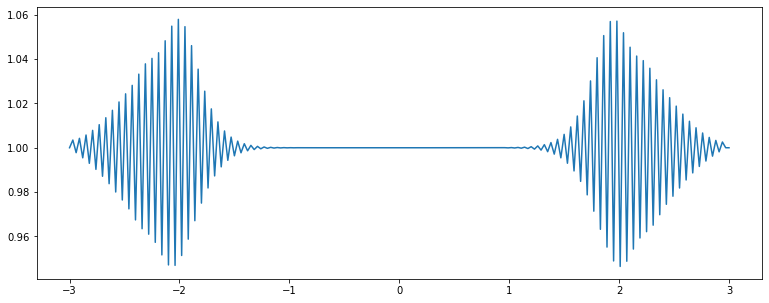

In [12]:
plt.figure(figsize = (13,5))
plt.plot(x, hm_old)

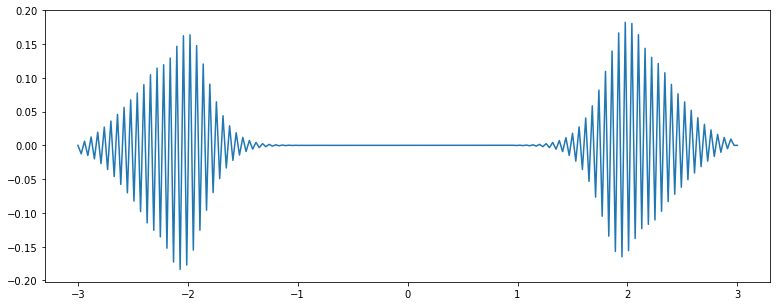

In [13]:
plt.figure(figsize = (13,5))
plt.plot(x, hm_old*um_old)

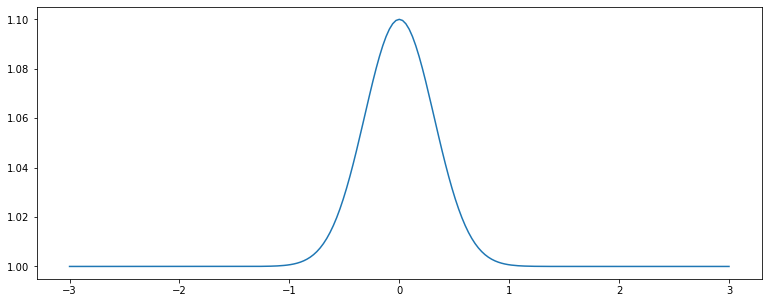

In [14]:
plt.figure(figsize = (13,5))
plt.plot(x, hm_old_t0)

## 2. Using staggered grid for non-conservative SWE (in the absence of coriolis forcing)

When we don't have coriolis forcing, or in other words, we are considering a non-rotating domain, the v-velocity identically reduces to zero. Therefore, we solve for $u_m$ and $h_m$.

In [15]:
#Length of domain
Lx = 6

#Number of points in the domain
nx = 256

#Width of each cell
dx = Lx/nx

g = 9
rho0 = 1025

#An array of all points
xu = np.linspace(-Lx/2,Lx/2,nx+1,dtype = float)
xt = xu + dx/2
xt = xt[0:-1]

# xu -> Grid for velocity/momentum variables
# xt -> Grid for tracer variables

In [16]:
%%time
#MLD_0 = -150*np.exp(0.05*x/Lx)

um_old = np.zeros(nx+1)
um_new = np.zeros(nx+1)

hm_old = 1 + 0.02*np.exp(-20*(xt)**2)
hm_old_t0 = 1 + 0.02*np.exp(-20*(xt)**2)
hm_new = np.zeros(nx)

t_start = 0
t_end = 3
dt = 0.001

# Needed to create animations
um_data = np.zeros((nx+1,int(t_end/dt) + 1))
hm_data = np.zeros((nx,int(t_end/dt) + 1))

for t in np.arange(t_start,t_end,dt):
    um_new[1:nx] = um_old[1:nx] - dt*elr.adv_x(um_old,um_old,dx,nx)[1:nx] - dt*g*(1/dx)*(
        hm_old[1:nx] - hm_old[0:nx-1])
    
    hm_new[1:nx-1] = hm_old[1:nx-1] - dt*(um_old[1:nx-1] + um_old[2:nx])*0.5*elr.partial_x_cd(
        hm_old,dx,nx)[1:nx-1] - dt*(1/dx)*(hm_old[1:nx-1]*(um_old[2:nx] - um_old[1:nx-1]))
    
    # Dirichlet boundary condition (Flips the wave along x-axis)
    #um_new[0] = 0
    #um_new[-1] = 0
    #hm_new[0] = 1
    #hm_new[-1] = 1
    
    # Neumann boundary condition (Acts like a mirror along y-axis)
    #hm_new[0] = hm_new[1]
    #hm_new[-1] = hm_new[-2]
    #um_new[0] = um_new[1]
    #um_new[-1] = um_new[-2]
    
    # Periodic boundary condition (Assumes that the two ends are connected)
    um_new[-1] = um_new[1]
    um_new[0] = um_new[-2]
    hm_new[-1] = hm_new[1]
    hm_new[0] = hm_new[-2]
    
    um_data[:,int(t/dt)] = um_new
    hm_data[:,int(t/dt)] = hm_new
    
    um_old = um_new
    hm_old = hm_new

CPU times: user 96.3 ms, sys: 3.74 ms, total: 100 ms
Wall time: 99.3 ms


### 2.1 Dirichlet boundary conditions

In [18]:
fig,ax = plt.subplots(figsize = (13,5))

def update_fig(i):
    
    plt.clf()
    plt.title('u-directional velocity for time = ' + str(dt*i))
    p1 = plt.plot(xu, um_data[:,i])
    plt.ylim([-0.05, 0.05])
    return p1

num_frames = 3000
anim = animation.FuncAnimation(fig, update_fig, frames = num_frames, blit = True)
anim.save('Videos/1D_SWE/1D_SWE_Cons_um.mp4',writer = 'ffmpeg',fps = 128)

plt.close(anim._fig)

In [19]:
Video("Videos/1D_SWE/1D_SWE_Cons_um.mp4")

In [20]:
fig,ax = plt.subplots(figsize = (13,5))

def update_fig(i):
    
    plt.clf()
    plt.title('Wave height for time = ' + str(dt*i))
    p1 = plt.plot(xt, hm_data[:,i])
    plt.ylim([0.975, 1.025])
    return p1

num_frames = 3000
anim = animation.FuncAnimation(fig, update_fig, frames = num_frames, blit = True)
anim.save('Videos/1D_SWE/1D_SWE_Cons_hm.mp4',writer = 'ffmpeg',fps = 128)

plt.close(anim._fig)

In [21]:
Video("Videos/1D_SWE/1D_SWE_Cons_hm.mp4")

### 2.2 Neumann boundary conditions

In [22]:
fig,ax = plt.subplots(figsize = (13,5))

def update_fig(i):
    
    plt.clf()
    plt.title('u-directional velocity for time = ' + str(dt*i))
    p1 = plt.plot(xu, um_data[:,i])
    plt.ylim([-0.05, 0.05])
    return p1

num_frames = 3000
anim = animation.FuncAnimation(fig, update_fig, frames = num_frames, blit = True)
anim.save('Videos/1D_SWE/1D_SWE_Cons_um_NBC.mp4',writer = 'ffmpeg',fps = 128)

plt.close(anim._fig)

In [23]:
Video("Videos/1D_SWE/1D_SWE_Cons_um_NBC.mp4")

In [24]:
fig,ax = plt.subplots(figsize = (13,5))

def update_fig(i):
    
    plt.clf()
    plt.title('Wave height for time = ' + str(dt*i))
    p1 = plt.plot(xt, hm_data[:,i])
    plt.ylim([0.975, 1.025])
    return p1

num_frames = 3000
anim = animation.FuncAnimation(fig, update_fig, frames = num_frames, blit = True)
anim.save('Videos/1D_SWE/1D_SWE_Cons_hm_NBC.mp4',writer = 'ffmpeg',fps = 128)

plt.close(anim._fig)

In [25]:
Video("Videos/1D_SWE/1D_SWE_Cons_hm_NBC.mp4")

### 2.3 Periodic boundary conditions

In [26]:
fig,ax = plt.subplots(figsize = (13,5))

def update_fig(i):
    
    plt.clf()
    plt.title('u-directional velocity for time = ' + str(dt*i))
    p1 = plt.plot(xu, um_data[:,i])
    plt.ylim([-0.05, 0.05])
    return p1

num_frames = 3000
anim = animation.FuncAnimation(fig, update_fig, frames = num_frames, blit = True)
anim.save('Videos/1D_SWE/1D_SWE_Cons_um_PBC.mp4',writer = 'ffmpeg',fps = 128)

plt.close(anim._fig)

In [27]:
Video("Videos/1D_SWE/1D_SWE_Cons_um_PBC.mp4")

In [28]:
fig,ax = plt.subplots(figsize = (13,5))

def update_fig(i):
    
    plt.clf()
    plt.title('Wave height for time = ' + str(dt*i))
    p1 = plt.plot(xt, hm_data[:,i])
    plt.ylim([0.975, 1.025])
    return p1

num_frames = 3000
anim = animation.FuncAnimation(fig, update_fig, frames = num_frames, blit = True)
anim.save('Videos/1D_SWE/1D_SWE_Cons_hm_PBC.mp4',writer = 'ffmpeg',fps = 128)

plt.close(anim._fig)

In [29]:
Video("Videos/1D_SWE/1D_SWE_Cons_hm_PBC.mp4")

As we see, the staggered grid works perfectly! In almost every general circulation model, a staggered grid is used. There are several staggered grids, named after Arakawa. A staggered grid is a grid where the momentum and tracer variables are placed on different grids in the domain, and often lead to more stability. 

## Test 3 : 1D SWE in the presence of coriolis forcing

This time around, we impose a mix of boundary conditions, each relevant to the particular tracer/momentum variable. We consider a realistic case: There is no-normal flow in the rotating fluid, so $u_m = 0$. Next, at the boundaries, since we have a shallow wave, we impose a constant wave height ($h_m = 1$ m). For v-velocity, we consider $\frac{\partial v}{\partial x} = 0$. 

In [30]:
#Length of domain
Lx = 6

#Number of points in the domain
nx = 256

#Width of each cell
dx = Lx/nx

g = 9
rho0 = 1025

#An array of all points
xu = np.linspace(-Lx/2,Lx/2,nx+1,dtype = float)
xt = xu + dx/2
xt = xt[0:-1]

In [31]:
#MLD_0 = -150*np.exp(0.05*x/Lx)

um_old = np.zeros(nx+1)
um_new = np.zeros(nx+1)
vm_old = np.zeros(nx+1)
vm_new = np.zeros(nx+1)
#hm_old = 0.1*np. exp(-(x-Lx/2)**2/(2**2))+10
#hm_old_t0 = 0.1*np. exp(-(x-Lx/2)**2/(2**2))+10
f = 2*omega*np.sin(np.deg2rad(30))*np.ones(xt.shape)

hm_old = 1 + 0.05*np.exp(-20*(xt)**2)
hm_old_t0 = 1 + 0.1*np.exp(-20*(xt)**2)
hm_new = np.zeros(nx)

t_start = 0
t_end = 2.5
dt = 0.001

# Needed to create animations
um_data = np.zeros((nx+1,int(t_end/dt) + 1))
vm_data = np.zeros((nx+1,int(t_end/dt) + 1))
hm_data = np.zeros((nx,int(t_end/dt) + 1))

for t in np.arange(t_start,t_end,dt):
    um_new[1:nx] = um_old[1:nx] - dt*elr.adv_x(um_old,um_old,dx,nx)[1:nx] - dt*g*(1/dx)*(
        hm_old[1:nx] - hm_old[0:nx-1]) + dt*(f[0:nx-1] + f[1:nx])*0.5*vm_old[1:nx]
    
    vm_new[1:nx] = vm_old[1:nx] - dt*elr.adv_x(um_old,vm_old,dx,nx)[1:nx] - dt*(
        f[0:nx-1] + f[1:nx])*0.5*um_old[1:nx]
    
    hm_new[1:nx-1] = hm_old[1:nx-1] - dt*(um_old[1:nx-1] + um_old[2:nx])*0.5*elr.partial_x_cd(
        hm_old,dx,nx)[1:nx-1] - dt*(1/dx)*(hm_old[1:nx-1]*(um_old[2:nx] - um_old[1:nx-1]))
    
    #Dirichlet boundary condition
    um_new[0] = 0
    um_new[-1] = 0
    #vm_new[0] = 0 
    #vm_new[-1] = 0
    hm_new[0] = 1
    hm_new[-1] = 1
    
    #Neumann boundary condition
    #hm_new[0] = hm_new[1]
    #hm_new[-1] = hm_new[-2]
    #um_new[0] = um_new[1]
    #um_new[-1] = um_new[-2]
    vm_new[-1] = vm_new[-2]
    vm_new[0] = vm_new[1]
    
    #Periodic boundary condition
    #um_new[-1] = um_new[1]
    #um_new[0] = um_new[-2]
    #vm_new[-1] = vm_new[1]
    #vm_new[0] = vm_new[-2]
    #hm_new[-1] = hm_new[1]
    #hm_new[0] = hm_new[-2]
    
    um_data[:,int(t/dt)] = um_new
    vm_data[:,int(t/dt)] = vm_new
    hm_data[:,int(t/dt)] = hm_new
    
    um_old = um_new
    vm_old = vm_new
    hm_old = hm_new

Text(0.5, 1.0, 'u-direction velocity at time = 2.499 s')

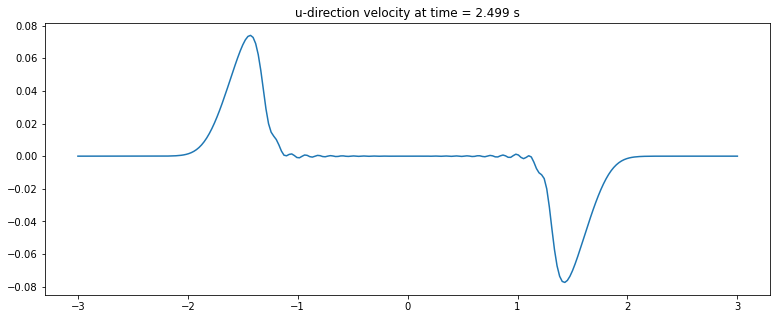

In [32]:
plt.figure(figsize = (13,5))
plt.plot(xu, um_new)
plt.title('u-direction velocity at time = ' + str(t) + ' s')

Text(0.5, 1.0, 'v-direction velocity at time = 2.499 s')

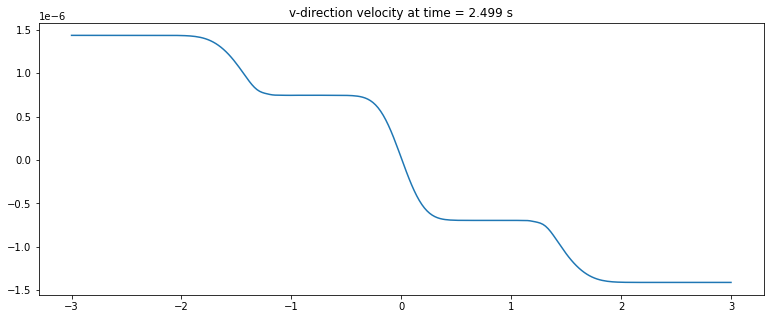

In [33]:
plt.figure(figsize = (13,5))
plt.plot(xu, vm_new)
plt.title('v-direction velocity at time = ' + str(t) + ' s')

Text(0.5, 1.0, 'Wave height at time = 2.499 s')

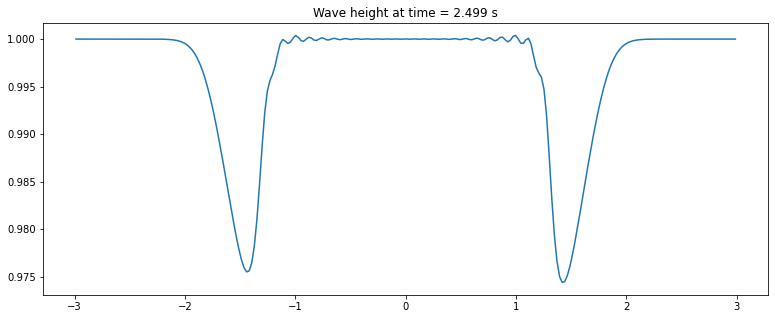

In [34]:
plt.figure(figsize = (13,5))
plt.plot(xt, hm_new)
plt.title('Wave height at time = ' + str(t) + ' s')

In [35]:
fig,ax = plt.subplots(figsize = (13,5))

def update_fig(i):
    
    plt.clf()
    plt.title('u-directional velocity for time = ' + str(dt*i*10))
    p1 = plt.plot(xu, um_data[:,i*10])
    plt.ylim([-0.08, 0.08])
    return p1

num_frames = 250
anim = animation.FuncAnimation(fig, update_fig, frames = num_frames, blit = True)
anim.save('Videos/1D_SWE/1D_SWE_coriolis_um.mp4',writer = 'ffmpeg',fps = 32)

plt.close(anim._fig)

In [36]:
Video('Videos/1D_SWE/1D_SWE_coriolis_um.mp4')

In [37]:
fig,ax = plt.subplots(figsize = (13,5))

def update_fig(i):
    
    plt.clf()
    plt.title('v-directional velocity for time = ' + str(dt*i*10))
    p1 = plt.plot(xu, vm_data[:,i*10])
    plt.ylim([-2e-6, 2e-6])
    return p1

num_frames = 250
anim = animation.FuncAnimation(fig, update_fig, frames = num_frames, blit = True)
anim.save('Videos/1D_SWE/1D_SWE_coriolis_vm.mp4',writer = 'ffmpeg',fps = 32)

plt.close(anim._fig)

In [38]:
Video('Videos/1D_SWE/1D_SWE_coriolis_vm.mp4')

In [39]:
fig,ax = plt.subplots(figsize = (13,5))

def update_fig(i):
    
    plt.clf()
    plt.title('Wave height for time = ' + str(dt*i*10))
    p1 = plt.plot(xt, hm_data[:,i*10])
    plt.ylim([0.95, 1.05])
    return p1

num_frames = 250
anim = animation.FuncAnimation(fig, update_fig, frames = num_frames, blit = True)
anim.save('Videos/1D_SWE/1D_SWE_coriolis_hm.mp4',writer = 'ffmpeg',fps = 32)

plt.close(anim._fig)

In [40]:
Video('Videos/1D_SWE/1D_SWE_coriolis_hm.mp4')